# Approximate q-learning

There is a lasagne neural network to do Q-learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GIVEN PARAMETERS FOR EXAMPLE

num_inner_iter = 500
num_outer_iter = 100

c = 4.0
gamma = 0.2
w = 0.87
delta = 0.2

n_actions = 10
n_states = 10
K = 5 # n_agents == K

In [3]:
# %%writefile env_auction2.py

class Auction:
    
    def __init__(self, n_actions, C_max, K, delta, w, L0):
        self.C_max = C_max
        self.n_actions = n_actions
        self.v = 1./K # clicks convirsion distribution
        self.K = K
        self.delta = delta
        self.w = w
        self.L = L0
        self.alpha = self.L.sum(axis=0) # bidding distribution 
        self.mu = np.array([1./C_max]*C_max) # Max-bid distribution
        
        self.actions = np.random.choice(np.arange(n_actions), size=K, p=self.alpha)
        self.state = np.random.choice(np.arange(C_max), p=self.mu) # current state of the representative Agent    
    
        self.all_s = []
        self.all_a = []
        self.transitions = {}
        self.transitions_counter = np.zeros((n_states, n_states))
        self.generate_auction_players()
        
    
    def generate_auction_players(self):
        self.population_idxs = np.arange(self.K)
        self.curr_agent = np.random.choice(self.population_idxs)
    
    def update_L(self, L):
        assert round(sum(sum(L)), 2) == 1, "Matrix L is not probability %s %s" % (L, L.sum())
        self.L = L 
        self.update_alpha()
        
    def update_alpha(self):
        self.alpha = self.L.sum(axis=0) 
        assert round(sum(self.alpha), 6) == 1, "self.alpha in not probability %s" % self.alpha
               
    def step(self, action, is_win):
        r = 0
        
        self.all_a.append(action)
        self.all_s.append(self.state)

        action_2nd = self.get_2nd_action(action)
        value = int(np.random.exponential(1) * self.K)
        if is_win:            
            r = value - action_2nd
            if action_2nd <= self.state:
                self.state -= action_2nd
            else: 
                r -= (1 + self.delta) * (action_2nd - self.state)
                self.state = 0
        
        done = 0
        assert self.state >= 0, "States colculated wrong!" 
        if self.state <= 0: # TODO: Better "=="
            done = 1
        
        rews = [0] * self.K
        if r != 0:
            rews[self.curr_agent] = r
        else:
            agents = np.delete(self.population_idxs, self.curr_agent)
            st_rnd_agent = np.random.choice(self.C_max, p=self.mu)
            r_rnd_agent = value - action_2nd
            if action_2nd > self.state:
                r_rnd_agent -= (1 + self.delta) * (action_2nd - st_rnd_agent)
            rews[np.random.choice(agents)] = r_rnd_agent
            
        self.transitions_counter[self.all_s[-1]][self.state] += 1
        return self.state, rews, done, _
    
    def get_2nd_action(self, action1):
        return sorted(self.actions)[-2]
    
    def reset(self):
        self.state = np.random.choice(np.arange(self.C_max), p=self.mu)
        
        self.all_s = []
        self.all_a = []
        
        self.generate_auction_players()
        self.actions = np.random.choice(np.arange(n_actions), size=K, p=self.alpha) #np.array([0] * n_agents)
        return self.state

In [4]:
L0 = np.array([1./(n_states * n_actions)] * (n_actions * n_states))
L0 = np.reshape(L0, (n_states, n_actions))

env = Auction(n_actions, n_states, K, delta, w, L0)
n_actions = env.n_actions
state_dim = (1,)

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with lasagne

First step is initializing input variables

In [5]:
import theano
import theano.tensor as T

current_actions = T.imatrix("actions[batch,agents]")
current_states = T.ivector("states[batch,1]")
rewards = T.vector("rewards[batch,1]")
next_states = T.ivector("next states[batch,1]")

In [6]:
import lasagne
from lasagne.layers import *

# input layer
l_states = InputLayer((None,)+state_dim)

layer = DenseLayer(l_states, 64, nonlinearity=lasagne.nonlinearities.rectify)

layer = DenseLayer(layer, 64)

# output layer
l_qvalues = DenseLayer(layer, num_units=n_actions, nonlinearity=None)

#### Predicting Q-values for `current_states`

In [7]:
# get q-values for ALL actions in current_states
predicted_qvalues = T.reshape(get_output(l_qvalues, {l_states: current_states}), (-1,n_actions))

# compiling agent's "get_qvalues" function
get_qvalues = theano.function([current_states], predicted_qvalues) 

# select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(current_actions.shape[0]), current_actions[:, env.curr_agent]]

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [8]:
# predict q-values for next states
predicted_next_qvalues = T.reshape(get_output(l_qvalues, {l_states: next_states}), (-1,n_actions))


# Computing target q-values under
target_qvalues_for_actions = rewards + gamma * predicted_next_qvalues.max(axis=1)


betta = np.array([0]*n_actions)
for a_i in range(n_actions):
    num_s_a = 1
    for i in range(len(env.all_s) - 1):
        if env.all_s[i] == env.all_s[-1] and env.all_a[i] == a_i:
            num_s_a += 1

    if num_s_a != 0:
        betta[a_i] =  1./(num_s_a ** (env.w)) 
    else :
        betta[a_i] = 0.0


# zero-out q-values at the end
target_qvalues_for_actions = target_qvalues_for_actions*(betta) + (1-betta)*predicted_qvalues_for_actions

# don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

# mean squared error loss function
loss = T.mean(T.sqr(predicted_qvalues_for_actions - target_qvalues_for_actions))
# loss = T.mean((predicted_qvalues_for_actions - target_qvalues_for_actions))

# all network weights
all_weights = get_all_params(l_qvalues, trainable=True)

# network updates. Note the small learning rate (for stability)
updates = lasagne.updates.adam(loss, all_weights, learning_rate=1e-5) #sgd or adam

# Training function that resembles agent.update(state,action,reward,next_state)
train_step = theano.function([current_states, current_actions, rewards, next_states],
                             updates=updates)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Playing the game

In [9]:
import random

def exp(x):
    return np.array([np.e ** i for i in x])
    
def softmax_c(x, c=c):
    x = np.array(x)
    e_cx = exp(c * x)
    if sum(e_cx) == 0:
        return e_cx * 0.
    return e_cx * 1. / sum(e_cx)

def get_action(q_values):
    q_values = softmax_c(q_values)    
    action_value = np.random.choice(q_values,p=q_values)
    action1 = np.random.choice(np.argwhere(q_values == action_value).flatten().tolist())

    a = np.random.choice(n_actions, size=K, p=env.alpha)
    a[env.curr_agent] = action1
    return a


def generate_session(t_max=10**4): # PLAY ONE GAME
    """play env with approximate q-learning agent and train it at the same time"""

    total_reward = 0
    s = env.reset() # state of representative agent

    for t in range(t_max): #T_k

        # get action q-values from the network
        q_values = get_qvalues([s])[0]
        env.actions = get_action(q_values)
        max_bids_ids = np.argwhere(env.actions == np.amax(env.actions)).flatten().tolist()
        
        if random.random() < 1./len(max_bids_ids):
            win = 1
        else:
            win = 0
        
        new_s, r, done, info = env.step(env.actions[env.curr_agent], win)

        train_step([s], [env.actions], [r[env.curr_agent]], [new_s])

        total_reward += r[env.curr_agent]

        s = new_s
        if done:
            break
    
    return total_reward

Norm =  0.005716561069821463
Alpha =  [0.50471 0.20256 0.0807  0.05522 0.04695 0.02122 0.03001 0.0211  0.0192
 0.01832]
Mean reward = 8.841999999999999
Norm for L =  0.00195749378948362


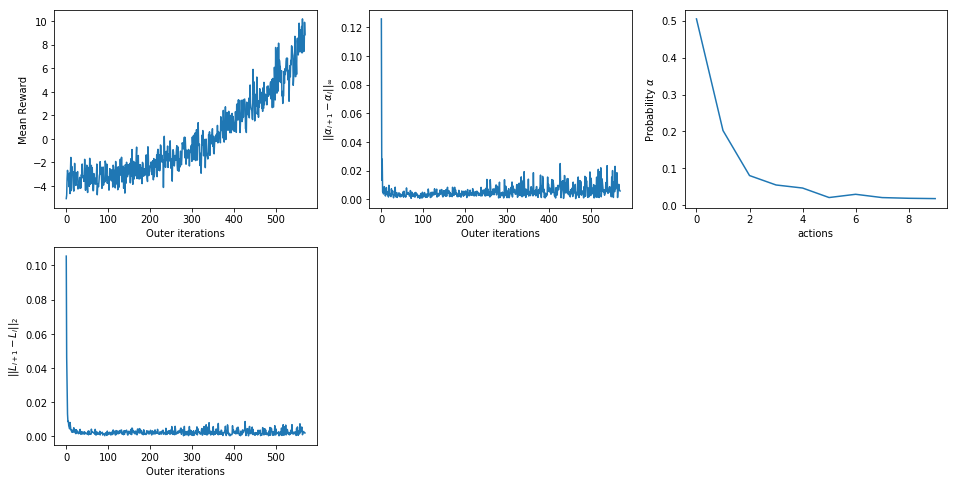

KeyboardInterrupt: 

In [10]:
%time

from IPython.display import clear_output

L = np.array([1./(n_states * n_actions)] * (n_actions * n_states))
L = np.reshape(L, (n_states, n_actions))

alpha_diffs = []
mean_rews = []
L_diffs = []
pred_alpha = L.sum(axis=0)
pred_L = np.copy(L)

for k in range(num_outer_iter*10):
    
    rewards = [generate_session(t_max=100) for _ in range(num_outer_iter)] # generate new sessions
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        q_val = get_qvalues([s])[0]
        policy[s] = softmax_c(q_val, c=4.)
    P = np.zeros((n_states, n_states))
    for i in range(n_states):
        P[i] = env.transitions_counter[i] * (1. / env.transitions_counter.sum())
    
    M = np.matmul(P, policy)
    L = np.copy(M)
    assert round(sum(sum(L)), 6) == 1, "Matrix L is not probability %s" % L
    env.update_L(L)
    

    mean_r = np.mean(rewards)
    alpha_diffs.append(np.linalg.norm(pred_alpha - env.alpha, np.inf))
    L_diffs.append(np.linalg.norm(np.subtract(L, pred_L), np.inf))
    mean_rews.append(mean_r)

    if k % 5 == 0:
        clear_output(True)
        print("Norm = ", np.linalg.norm(pred_alpha - env.alpha, np.inf))
        print("Alpha = ", np.around(env.alpha, 5))
        print('Mean reward =', mean_r)
        print("Norm for L = ", np.linalg.norm(np.subtract(L, pred_L), np.inf))
        
        f = plt.figure(figsize=(16, 8))
        
        f.add_subplot(2,3,1)
        plt.xlabel('Outer iterations')
        plt.ylabel('Mean Reward')
        plt.plot(mean_rews)
        
        f.add_subplot(2,3,2)
        plt.xlabel('Outer iterations')
        plt.ylabel(r'$||\alpha_{i+1} - \alpha_{i}||_{\infty}$')
        plt.plot(alpha_diffs)
        
        f.add_subplot(2,3,3)
        plt.xlabel('actions')
        plt.ylabel(r'Probability $\alpha$')
        plt.plot(env.alpha)
        
        f.add_subplot(2,3,4)
        plt.xlabel('Outer iterations')
        plt.ylabel(r'$||L_{i+1} - L_{i}||_{2}$')
        plt.plot(L_diffs)
        plt.show(block=True)
        
    pred_alpha = list(env.alpha)
    pred_L = np.copy(env.L)